<a href="https://colab.research.google.com/github/rahuldey5156/Deep-Learning-using-Python/blob/main/GANs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Import the necessary libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, LeakyReLU, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD, Adam

Loading the MNIST Dataset

In [2]:
mnist = tf.keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()

11490434/11490434 [==============================] - 0s 0us/step


Scale the inputs in range of (-1, +1) for better training

In [3]:
x_train, x_test = x_train / 255.0 * 2 - 1, x_test / 255.0 * 2 - 1

Plot some example images from the training datasets

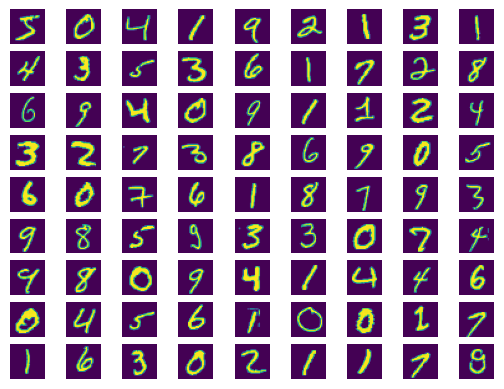

In [4]:
for i in range(81):
  plt.subplot(9, 9, i+1)
  plt.axis("off")
  #plot raw pixel data
  plt.imshow(x_train[i])
plt.show()

Flattening 3D datasets to 2D datasets and converting the image size from 28*28 to 684

In [5]:
N, H, W = x_train.shape
D = H * W
x_train = x_train.reshape(-1, D)
x_test = x_test.reshape(-1, D)

Define the Generator Model

In [8]:
latent_dim = 100
def build_generator(latent_dim):
  i = Input(shape=(latent_dim,))
  x = Dense(256, activation=LeakyReLU(alpha=0.2))(i)
  x = BatchNormalization(momentum=0.7)(x)
  x = Dense(512, activation=LeakyReLU(alpha=0.2))(x)
  x = BatchNormalization(momentum=0.7)(x)
  x = Dense(1024, activation=LeakyReLU(alpha=0.2))(x)
  x = BatchNormalization(momentum=0.7)(x)
  x = Dense(D, activation='tanh')(x)
  model = Model(i, x)
  return model

Define the Discriminator Model

In [9]:
def build_discriminator(img_size):
  i = Input(shape=(img_size,))
  x = Dense(512, activation=LeakyReLU(alpha=0.2))(i)
  x = Dense(256, activation=LeakyReLU(alpha=0.2))(x)
  x = Dense(1, activation='sigmoid')(x)
  model = Model(i, x)
  return model

Build and compile the discriminator

In [10]:
discriminator = build_discriminator(D)
discriminator.compile ( loss='binary_crossentropy', optimizer=Adam(0.0002, 0.5), metrics=['accuracy'])

Build the generator

In [11]:
generator = build_generator(latent_dim)

Create Noise Sample

In [12]:
z = Input(shape=(latent_dim,))
img = generator(z)
discriminator.trainable = False
fake_pred = discriminator(img)

Create generator model

In [13]:
combined_model_gen = Model(z, fake_pred)

Compile the combined model

In [14]:
combined_model_gen.compile(loss='binary_crossentropy', optimizer=Adam(0.0002, 0.5))

Define the parameters for training GANs

In [15]:
batch_size = 32
epochs = 12000
sample_period = 200
ones = np.ones(batch_size)
zeros = np.zeros(batch_size)

Store generator and discriminator loss in each epoch

In [16]:
g_losses = []
d_losses = []

Create a file for generator to create and save images

In [17]:
if not os.path.exists('GAN_Images'):
  os.makedirs('GAN_Images')

Create sample images

In [18]:
def sample_images(epoch):
  rows, cols = 5, 5
  noise = np.random.randn(rows * cols, latent_dim)
  imgs = generator.predict(noise)
  # Rescale images 0 - 1
  imgs = 0.5 * imgs + 0.5
  fig, axs = plt.subplots(rows, cols)
  idx = 0
  for i in range(rows):  #5*5 loop implies there will be 49 images on page
    for j in range(cols):
      axs[i,j].imshow(imgs[idx].reshape(H, W), cmap='gray')
      axs[i,j].axis('off')
      idx += 1
  fig.savefig("GAN_Images/%d.png" % epoch)
  plt.close()

Train the discriminator followed by the generator to generate the images

In [20]:
for epoch in range(epochs):
  idx = np.random.randint(0, x_train.shape[0], batch_size) #Select a random batch of images
  real_imgs = x_train[idx]  #Train the discriminator

  noise = np.random.randn(batch_size, latent_dim)  #Generator for generating fake images
  fake_imgs = generator.predict(noise)
  # Train the discriminator
  d_loss_real, d_acc_real = discriminator.train_on_batch(real_imgs, ones)  #Both loss and accuracy are returned for the real images
  d_loss_fake, d_acc_fake = discriminator.train_on_batch(fake_imgs, zeros)  #Both loss and accuracy are returned for the fake images
  d_loss = 0.5 * (d_loss_real + d_loss_fake) #Average loss
  d_acc  = 0.5 * (d_acc_real + d_acc_fake) #Average accuracy

  #Train the generator
  noise = np.random.randn(batch_size, latent_dim)
  g_loss = combined_model_gen.train_on_batch(noise, ones)
  #Here we are attempting to fool the discriminator that generate images are real. Due to this reason, we are labeling it as 1.
  #Repeat the step!
  noise = np.random.randn(batch_size, latent_dim)
  g_loss = combined_model_gen.train_on_batch(noise, ones)

  d_losses.append(d_loss)  #Save the loss at each epoch
  g_losses.append(g_loss)
  if epoch % 100 == 0:
    print(f"epoch: {epoch+1}/{epochs}, d_loss: {d_loss:.2f}, d_acc: {d_acc:.2f}, g_loss: {g_loss:.2f}")
  if epoch % sample_period == 0:
    sample_images(epoch)

Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 30ms/step
epoch: 7101/12000, d_loss: 0.67, d_acc: 0.59, g_loss: 0.78
1/1 [==============================] - 0s 33ms/step
epoch: 7201/12000, d_loss: 0.67, d_acc: 0.61, g_loss: 0.77
1/1 [==============================] - 0s 31ms/step
epoch: 7301/12000, d_loss: 0.72, d_acc: 0.50, g_loss: 0.75
1/1 [==============================] - 0s 27ms/step
epoch: 7401/12000, d_loss: 0.69, d_acc: 0.53, g_loss: 0.80
1/1 [==============================] - 0s 26ms/step
epoch: 7501/12000, d_loss: 0.67, d_acc: 0.61, g_loss: 0.76
1/1 [==============================] - 0s 25ms/step
epoch: 7601/12000, d_loss: 0.73, d_acc: 0.55, g_loss: 0.82
1/1 [==============================] - 0s 27ms/step
epoch: 7701/12000, d_loss: 0.72, d_acc: 0.38, g_loss: 0.74
1/1 [==============================] - 0s 27ms/step
epoch: 7801/12000, d_loss: 0.73, d_acc: 0.48, g_loss: 0.74
1/1 [==============================] - 0s 27ms/step
epoch: 79

Plot the loss function

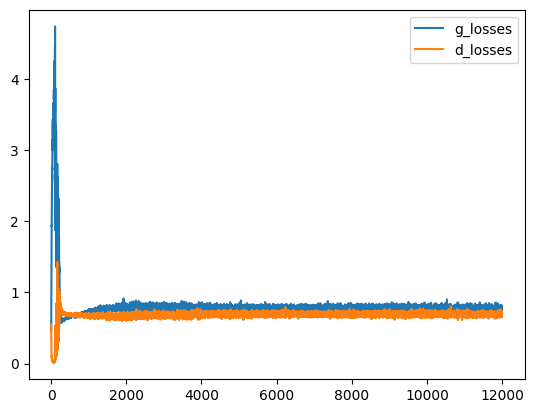

In [21]:
plt.plot(g_losses, label='g_losses')
plt.plot(d_losses, label='d_losses')
plt.legend()

Observe the result

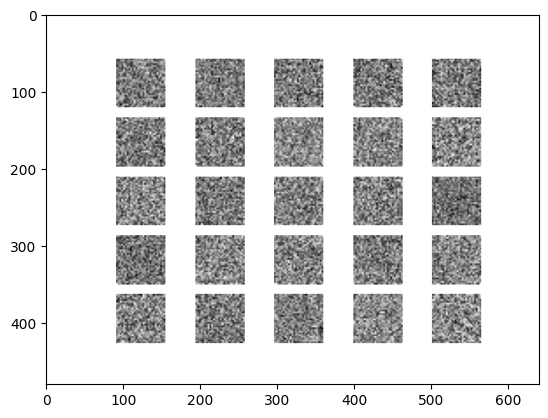

In [22]:
#Plot the generated image at 0 epoch
from skimage.io import imread
a = imread('GAN_Images/0.png')
plt.imshow(a)

**Observation**: There is no information that can be extracted from the generator, whereas the discriminator is capable enough to identify the fake case.

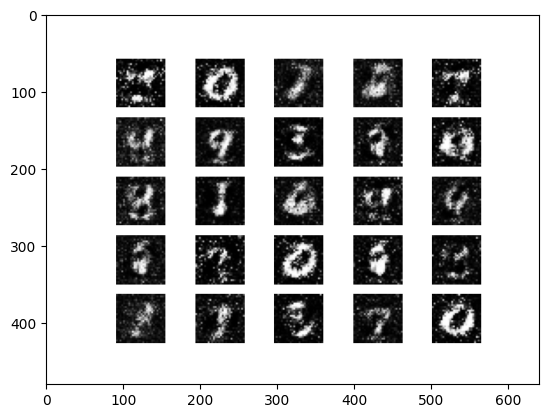

In [23]:
#Plot the generated image at 1000 epoch
from skimage.io import imread
a = imread('GAN_Images/1000.png')
plt.imshow(a)

**Observation**: The generator is gradually extracting some information. However, it is not good enough to fool the discriminator.

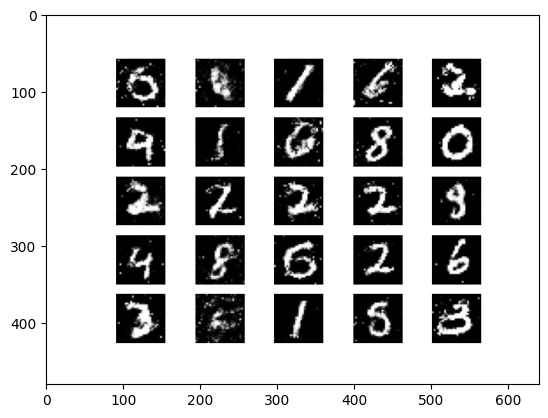

In [24]:
#Plot the generated image at 10000 epoch
from skimage.io import imread
a = imread('GAN_Images/10000.png')
plt.imshow(a)

**Observation**: Finally, the generator has built the images with the same qualities as the MNIST dataset, and there are healthy chances of making the discriminator fool.